# HW09: More Solving of Ordinary Differential Equations (ODEs)

## Problem 1: Solve the following differential equation using odeint

If you are living on the International Space Station and accidentally get ejected into space without a space suit, you would need to get air within a few minutes to prevent death. Even if you have air, if you aren't kept warm, your body would be hypothermic in a relatively short period. Let find out how long you have to get back to the space station before becoming hypothermic. There are likely other more deadly conditions of being exposed to a vacuum than running out of oxygen or freezing, but we will ignore those for now.

Assuming your are on the shadowed side of Earth, the following is a simple model that describes how your body's average temperature $T$ could change in time. The term on the left is the accumulation term; the first term on the right is a generation term (from your metabolism); the second term on the right is emission by radiation into space (space does not return any radiation to you). 

$$ m c_p\frac{dT}{dt} = \dot{Q}- \sigma A T^4$$

where $m$ is total body mass, $c_p$ is heat capacity, $\dot{Q}$ is heat generation by your body, $A$ is effective surface area of your body that emits radiation, and $\sigma$ is the Stefan-Boltzmann radiation constant (look it up online). 

Your code should be well-documented and all constants should be specified with units. You should use SI units generally in this problem, though will need to switch between $\mathrm{K}$ and $^\circ\mathrm{C}$. A couple notes on that: Temperature in the radiation term must be absolute (i.e. units $\mathrm{K}$). Recall from ChEn 170 that for heat capacity the denominator contains a change in temperature (i.e. either $\Delta\mathrm{K}$ or $\Delta^\circ\mathrm{C}$ which are perfectly the same). Once you get an answer in $\mathrm{K}$ you will need to convert to $^\circ\mathrm{C}$ in the final plot. 

To solve this problem you need to do the following. 
1. Reasonably estimate the values of $m$ and $A$ for your body (or for 'a friend'). The area that emits radiation could be estimated, for instance, by treating your body as if it were a cylinder of water.
2. Assume $c_p$ for your body is the value for water
3. Reasonably estimate what your $\dot{Q}$ would be in this scenario: a person while resting generates about $100~\mathrm{W}$ heat and while vigorously exercising generates around $300~\mathrm{W}$.
4. Rearrange the above equation and determine what is needed to implement into `odeint`
5. Make a smooth well-formatted plot of body temperature ($^\circ\mathrm{C}$) over time ($\mathrm{s}$). Adjust the timescale so that the plot readily shows the most relevant region of interest.
6. Based on the **plot** of the model result, **estimate** the time when you would get to hypothermia. Normal body temperature is $37^\circ\mathrm{C}$; hypothermia begins at $35^\circ\mathrm{C}$.


In [1]:
#Your answer here

## Problem 2: Relatively Simple Climate Model
The earth's climate is very complex. "A butterfly flaps its wings in China and it rains in New York" is a popular saying that illustrates the complexity of the climate system. Climate models are very complex. In this homework, we will use a simple climate model to explore the effect of the greenhouse effect on the earth's temperature. 

We'll simulate a layer of dry air on top of a layer of humid air that is above a layer of solid iron. Our model will be significantly smaller than the Earth. Oxygen and nitrogen are transparent to both visible and infrared light, but water vapor and carbon dioxide are not. The greenhouse effect is the process by which the atmosphere traps infrared radiation and warms the earth. We need this effect to survive otherwise the earth would be too cold to support life. 

Incoming solar radiation ($I_0$) is absorbed by the different layers, heating them, and some of that energy strikes the Earth's surface. The surface then radiates infrared radiation (I1) back into the atmosphere. Some of this radiation is absorbed by the atmosphere, and some escapes into space. 

Table of Parameters 
|Number|Label|$C_p$, J/mol/K|Reflectivity|Temp, K|Absorption coef., m-1|Emissivity|Thickness, m|Heat transfer coef., kW/m2/K|
|------|-----|-----|----------|----|----------|--------|---------|-------------------|
|1|Dry Air|29|0.02|256|<mark>0.01</mark>|0.3|90|100|
|2|Humid Air|36|<mark>0.2</mark>|263|0.7|0.8|30|100|
|3|Iron|25|0|285|100|0.5|1|1|

The highlighted values are the parameters that will be changing depending on the composition of the dry and humid air.

Energy balance equations that define the behavior and interactions between the layers:

$$
\begin{align}
acc &= in - out \\
\frac{dE_i}{dt} &= n_iC_p^i\frac{dT_i}{dt}= I_{i-1}A_i[(1-r_i)-(1-r_i)^2 e^{-\kappa_i d_i}] -\sigma \epsilon_i A_i(T_i^4-T_{surr}^4) -\sum h_{ij}B_{ij}(T_i-T_j)
\end{align}
$$

where $E$ is the energy stored in each layer, $n$ is the number of moles of each layer, $C_p$ is the heat capacity of each layer, $T$ is the temperature of each layer, $I_0$ is the incoming solar radiation, $A$ is the surface area of the earth, $r$ is the reflectivity of each layer, $\kappa$ is the absorption coefficient of each layer, $d$ is the thickness of each layer, $\sigma$ is the Stefan-Boltzmann constant, $\epsilon$ is the emissivity of each layer, $B$ is the interfacial area, and $h$ is the heat transfer coefficient of each layer.

For example, for the second layer, the above derivative equation is

$$
\frac{dE_2}{dt} = n_2C_p^2\frac{dT_2}{dt}= I_1A_2[(1-r_2)-(1-r_2)^2 e^{-\kappa_2 d_2}] - \sigma \epsilon_2 A_2(T_2^4 - T_{surr}^4) - h_{23}B_{23}(T_2-T_3) - h_{21}B_{21}(T_2-T_1)
$$

The outlet radiation after it passes through a layer is:

$$
I_i = I_{i-1}(1-r_i)^2 e^{-\kappa_i d_i}
$$

An image of the different layers for this model is shown below with the different layers labeled and the incoming radiation through Layer 1. Now we can set up our model in Python.

<img src="https://github.com/clint-bg/comptools/blob/main/homework/supportfiles/sphere-climate.png?raw=true" width='350'>

In [4]:
#import dependencies
import param
import numpy as np
from scipy.integrate import odeint
from matplotlib import pyplot as plt

In [5]:
class layer(param.Parameterized):
    th = param.Number(default=1000, doc="Thickness of the layer, m")
    k = param.Number(default=0, doc="absorbtion coefficient of the layer, m^-1")
    T = param.Number(default=288, doc="Temperature of the layer, K")
    Cp = param.Number(default=1, doc="Heat capacity of the layer, J/(mol K)")
    em = param.Number(default=0.9, doc="Emissivity of the layer")
    sigma = param.Number(default=5.67e-8, doc="Stefan-Boltzmann constant, W/(m^2 K^4)")
    ref = param.Number(default=0.5, doc="Reflectivity of the layer")
    rad = param.Number(default=1, doc="Radius to edge of layer closest to center, m")
    Rg = param.Number(default=8.314, doc="Ideal gas constant, J/(mol K)", constant = True)
    hconv = param.Number(default=10, doc="Convection coefficient, W/(m^2 K)")
    solid = param.Boolean(default=False, doc="Is the layer solid?")
    solidensity  = param.Number(default=1500, doc="Density of the solid, kg/m^3")
    MW = param.Number(default=0.0558, doc="Molecular weight of the component, kg/mol")

    def area(self): #area for the emission to the surroundings taken to be the outside surface area
        return 4*np.pi*(self.rad+self.th)**2

    def moles(self,pressure):
        volume = 4/3*np.pi*((self.rad+self.th)**3 - (self.rad)**3)
        if self.solid:
            return self.solidensity*volume/self.MW
        else:
            return pressure*volume/(self.Rg*self.T)
    
    def adsorbed(self,Ii): # energy adsorbed by the layer
        return Ii*((1-self.ref)-(1-self.ref)**2*np.exp(-self.k*self.th))*self.area() #Ii is the intensity of the incoming radiation
    
    def emitted(self,Tsurr): # energy radiated by the layer to the surroundings
        return self.em*self.sigma*self.area()*(self.T**4 - Tsurr**4)
    
    def convection(self,upperlayer, lowerlayer): # energy convected by the layer to the other layers
        hc_u = (self.hconv + upperlayer.hconv)/2
        hc_l = (self.hconv + lowerlayer.hconv)/2
        area_u = self.area(); area_l = 4*np.pi*(self.rad)**2
        if upperlayer == self:
            heat_u = hc_u*(self.T - 250)*area_u #heat lost to space from the top layer
        elif lowerlayer == self:
            heat_u = hc_u*(self.T - 290)*area_u #mimicking heat from the earth's core to the bottom layer
        else:
            heat_u = hc_u*(self.T - upperlayer.T)*area_u
        heat_l = hc_l*(self.T - lowerlayer.T)*area_l
        return heat_u + heat_l
    
    def dTdt(self,Ii,Tsurr,pressure,upperlayer,lowerlayer): # change in temperature with time of the layer
        conv = self.convection(upperlayer, lowerlayer)
        return (self.adsorbed(Ii) - self.emitted(Tsurr) - conv)/(self.moles(pressure)*self.Cp)    

**Task 1:** Please describe what the above code is doing. Also please explain what is meant by upperlayer and lowerlayer.




When rerunning the code, make sure to rerun from here (where the objects are defined at their initial values.)

In [18]:
#Now simulate the layers with a given intensity of incoming radiation and 
# a given temperature of the surroundings
years = 10
time = np.linspace(0,365*years,3650*years) #days 
Tsurr = 0 #K
pressure = 1e5 #Pa
hc = 100 #W/(m^2 K) #convection coefficient for all layers
radius = 100 #m, radius of the planet
dryair = layer(th=90, k = 0.01, T = 256, Cp = 29, em = 0.3, ref = 0.02, rad = radius+30+1, hconv = hc)
wetair = layer(th=30, k = 0.7, T = 263, Cp = 36, em = 0.8, ref = 0.2, rad = radius+1, hconv = hc)
iron = layer(th=1, k = 100, T = 285, Cp = 25, em = 0.5, ref = 0, rad = radius, hconv = 1, solid=True)

In [19]:
#set radiation intensity
Io = 1.5e3 #W/m^2
def Ii(day):
    return (np.sin(2*np.pi*day)+1)*Io/2 #W/m^2  

#set absorption coefficient of dryair mimicking increase in CO2 concentration step change
def ad(day):
    if day>1000:
        dryair.k = 10

#set reflectivity of wetair mimicking increase in cloud cover step change
def refl(day):
    if day>1000:
        wetair.ref = 1

**Task 2** Please describe what the ad() and refl() functions are doing. What is being set in each case? How would you expect the temperature to change in response? How long will that setting last?

(1000.0, 1035.0)

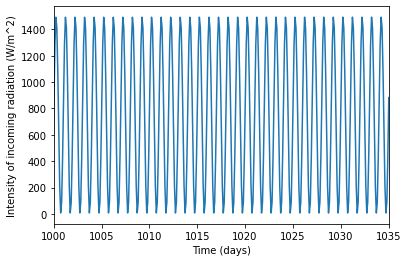

In [20]:
plt.plot(time,Ii(time))
plt.xlabel("Time (days)"); plt.ylabel("Intensity of incoming radiation (W/m^2)")
plt.xlim([1000,1035])

**Task 3**: You will make changes to the "atmosphere" by either increasing the cloud cover with the refl() function, or increasing the absorption coefficient of the atmosphere. You will either uncomment the ad(t) or refl(t) function in the below derivative to see how the atmosphere (dryair temperature) responds. Remember to rerun the code from the beginning (at Task 1) to reset the initial values.

In [21]:
#Integrate the differential equations using ODEINT
def derivs(T,t,Ii,ad):
    [dryair.T,wetair.T,iron.T] = T #set the temperatures of the layers from the odeint results
    #ad(t) #change the absorption coefficient of dryair
    #refl(t) #change the reflectivity of wetair
    I0 = Ii(t)
    I1 = Ii(t)*(1-dryair.ref)**2*np.exp(-dryair.k*dryair.th)
    I2 = I1*(1-wetair.ref)**2*np.exp(-wetair.k*wetair.th)
    return [dryair.dTdt(I0,Tsurr,pressure,dryair,wetair), \
        wetair.dTdt(I1,Tsurr,pressure,dryair,iron), \
            iron.dTdt(I2,Tsurr,pressure,wetair,iron)]
T0 = [dryair.T,wetair.T,iron.T]
args = (Ii,ad)
results = odeint(derivs,T0,time,args)
first = np.array([each[0] for each in results])
second = np.array([each[1] for each in results])
third = np.array([each[2] for each in results])

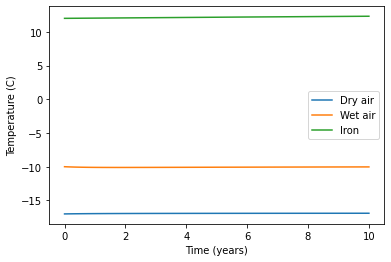

In [22]:
#Plot the results
plt.plot(time/365,first-273,label = "Dry air")
plt.plot(time/365,second-273,label = "Wet air")
plt.plot(time/365,third-273,label = "Iron")
plt.xlabel("Time (years)")
plt.ylabel("Temperature (C)")
plt.legend()
plt.show()

**Task 4:** Please comment on your observations: How does increasing the cloud cover affect the temperature of the different layers. How does increasing the absorption coefficient of the dryair layer affect the temperature of the different layers?






In [23]:
#changes in temperature
(dryair.T-256,wetair.T-263,iron.T-285)

(0.09828641514332048, -0.030317701606008995, 0.31149164540840957)

## Problem 3: Earth's Climate and CO2
Billions of dollars is being spent to reduce the CO2 concentration in our atmosphere. There are multiple pieces of evidence, as presented by the US Government in the below links, that may show that these expenses are justified. Please quickly review the below links.

Gasonline and diesel consumption for US vehicles
https://www.statista.com/statistics/189410/us-gasoline-and-diesel-consumption-for-highway-vehicles-since-1992/

Greenhouse Gas Index
https://www.climate.gov/news-features/understanding-climate/climate-change-annual-greenhouse-gas-index

Atmospheric CO2 Concentration
https://www.climate.gov/news-features/understanding-climate/climate-change-atmospheric-carbon-dioxide

Global Surface Temperatures
https://www.climate.gov/news-features/understanding-climate/climate-change-global-temperature

What other data would you like to see to corroborate the above data? For example, CxHy + O2 -> CO2 + H2O. Would you expect the concentration of oxygen to increase or decrease?  If the CO2 concentration is increasing, would you expect the density of the atmosphere to increase or decrease?

It's been put forward that the CO2 concentration increase is not only correlated to the apparent rise in the atmospheric temperature but that it is the cause. This cause and effect relationship is not necessarily true, but it may be. How would you go about proving or disproving this?

It has also been put forward that water content in the atmosphere shouldn't be a part of the discussion even though the greenhouse effect of water vapor is much more significant that other gases. What are your thoughts on this?



`Your answers here`